# An example of the Expectation-Maximization (EM) algorithm

We consider a sample $Y_1, \dots, Y_n$ from the mixture density

$$ (1-p)\phi_{\mu_0, 1}(y) + p\phi_{\mu_1,1}(y),$$

where $\phi_{\mu,\sigma}(y)$ is the Gaussian density with mean $\mu$ and variance $\sigma$, to illustrate the EM algorithm used to find the maximum likelihood estimator of the parameters.

## Generate dataset

We start by generating a dataset consisting of 100 samples with $p=0.3$, $\mu_0 = 0$ and $\mu_1 = 10$.

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [230]:
n = 100

sample = []
cl = [] # To store the class indices

p = 0.3
mu0 = 0
mu1 = 10

# There is probably a better way to do this...
for i in range(n):
    u = np.random.rand();
    if (u <= 1-p):
        sample.append(np.random.normal(mu0,1));
        cl.append(0)
    else:
        sample.append(np.random.normal(mu1,1));
        cl.append(1)
        
data = pd.DataFrame(list(zip(sample,cl)), columns = ['Sample', 'Type'])

In [231]:
data.head()

,Sample,Type
0,-0.240692,0
1,-0.493698,0
2,-1.795212,0
3,-0.403817,0
4,10.315741,1


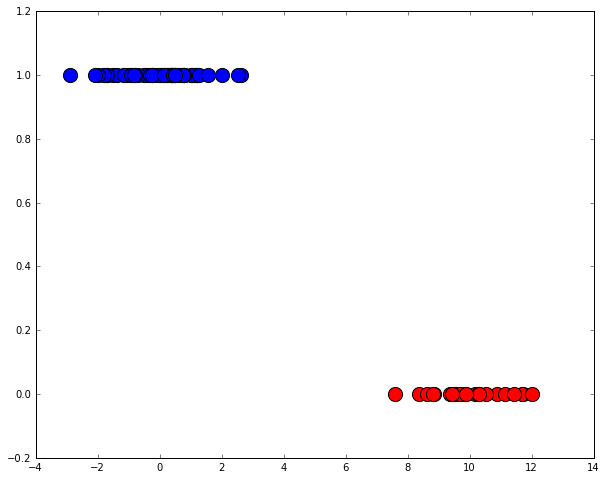

In [232]:
plt.figure(figsize=(10,8))
type1_data = data[data.Type == 1]
type0_data = data[data.Type == 0]
plt.scatter(type1_data.Sample, np.zeros(len(type1_data)), s = 200, c = 'r');
plt.scatter(type0_data.Sample, np.ones(len(type0_data)), s = 200, c = 'b');

plt.show()

## The iteration rule

Now we implement a function carrying out the iterative step using the formulas derived in class. Recall that we first introduced the auxiliary quantity

$$\tau_i^{(j)} = \frac{p^{(j)}\phi_{\mu_1^{(j)},1}(y_i)}{p^{(j)}\phi_{\mu_1^{(j)},1}(y_i)+(1-p^{(j)})\phi_{\mu_0^{(j)},1}(y_i)}$$

in terms of which the update rule takes the form

$$p^{(j+1)}=\frac{1}{n}\sum_{i=1}^n\tau_i^{(j)},\qquad\mu_0^{(j+1)}=\frac{\sum_{i=1}^ny_i(1-\tau_i^{(j)})}{\sum_{i=1}^n(1-\tau_i^{(j)})},\qquad \mu_1^{(j+1)}=\frac{\sum_{i=1}^ny_i\tau_i^j}{\sum_{i=1}^n\tau_i^j}$$


In [233]:
from scipy import stats

In [234]:
def tau(p, mu0, mu1, data):
    # Computes the tau-factors
    a = stats.norm.pdf(data, loc=mu0, scale=1);
    b = stats.norm.pdf(data, loc=mu1, scale=1);
    
    return p * b / (p * b + (1-p) * a)
    
def update(p_old, mu0_old, mu1_old, y_data):
    # Update rule for the iteration
    if p_old == 1:
        return [1, mu0_old, y_data.mean()]
    elif p_old == 0:
        return [0, y_data.mean(), mu1_old]
    else:
        tau_factors = tau(p_old, mu0_old, mu1_old, y_data);
        p_new = tau_factors.mean()
        mu0_new = np.dot(y_data, 1-tau_factors) / (1-tau_factors).sum()
        mu1_new = np.dot(y_data, tau_factors) / tau_factors.sum()
        return [p_new, mu0_new, mu1_new]

def log_likelihood(p, mu0, mu1, data):
    return (np.log((1-p)*stats.norm.pdf(data, loc=mu0, scale=1) + p * stats.norm.pdf(data, loc=mu1, scale=1))).sum();

## The iteration

In [244]:
initial_theta = [0.3, 0, 1]

In [245]:
num_of_iter = 20

theta = initial_theta
ll = log_likelihood(theta[0], theta[1], theta[2], data.Sample)
print("Initial: {} log-Likelihood: {:.2f}".format(theta, ll))

for i in range(num_of_iter):
    theta = update(theta[0], theta[1], theta[2], data.Sample)
    ll = log_likelihood(theta[0], theta[1], theta[2], data.Sample)
    print("{:2d}. p: {:.2f}, mu0: {:.2f}, mu1: {:.2f}   log-Likelihood: {:.2f} ".format(i+1,theta[0],theta[1],theta[2], ll))

Initial: [0.3, 0, 1] log-Likelihood: -1857.39
 1. p: 0.36, mu0: 0.05, mu1: 1.56   log-Likelihood: -1768.31 
 2. p: 0.37, mu0: -0.07, mu1: 1.77   log-Likelihood: -1750.62 
 3. p: 0.37, mu0: -0.12, mu1: 1.85   log-Likelihood: -1748.09 
 4. p: 0.36, mu0: -0.13, mu1: 1.88   log-Likelihood: -1747.73 
 5. p: 0.36, mu0: -0.12, mu1: 1.90   log-Likelihood: -1747.58 
 6. p: 0.35, mu0: -0.12, mu1: 1.91   log-Likelihood: -1747.47 
 7. p: 0.35, mu0: -0.11, mu1: 1.92   log-Likelihood: -1747.38 
 8. p: 0.35, mu0: -0.11, mu1: 1.93   log-Likelihood: -1747.30 
 9. p: 0.35, mu0: -0.10, mu1: 1.94   log-Likelihood: -1747.24 
10. p: 0.34, mu0: -0.10, mu1: 1.94   log-Likelihood: -1747.18 
11. p: 0.34, mu0: -0.10, mu1: 1.95   log-Likelihood: -1747.14 
12. p: 0.34, mu0: -0.09, mu1: 1.96   log-Likelihood: -1747.10 
13. p: 0.34, mu0: -0.09, mu1: 1.96   log-Likelihood: -1747.07 
14. p: 0.33, mu0: -0.09, mu1: 1.97   log-Likelihood: -1747.04 
15. p: 0.33, mu0: -0.08, mu1: 1.97   log-Likelihood: -1747.02 
16. p: 0.3

We see that the algorithm quickly settles in to two sets of values it then oscillates in between. This is because the role of the components of the mixture are perfectly symmetric. Indeed the two sets of values are mirror images of each other.

## Non-separable data

The above situation worked well because the two components of the mixture were well separated. Let us look at the case of non-separable data.

In [241]:
n = 1000

sample = []
cl = []

p = 0.3
mu0 = 0
mu1 = 2

# There is probably a better way to do this...
for i in range(n):
    u = np.random.rand();
    if (u <= 1-p):
        sample.append(np.random.normal(mu0,1));
        cl.append(0)
    else:
        sample.append(np.random.normal(mu1,1));
        cl.append(1)
        
data = pd.DataFrame(list(zip(sample,cl)), columns = ['Sample', 'Type'])

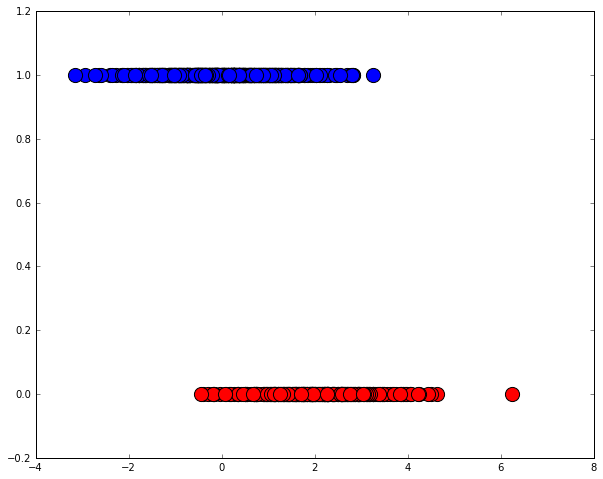

In [242]:
plt.figure(figsize=(10,8))
type1_data = data[data.Type == 1]
type0_data = data[data.Type == 0]
plt.scatter(type1_data.Sample, np.zeros(len(type1_data)), s = 200, c = 'r');
plt.scatter(type0_data.Sample, np.ones(len(type0_data)), s = 200, c = 'b');

plt.show()

In [243]:
initial_theta = [0.3, 0, 2]

num_of_iter = 20

theta = initial_theta
ll = log_likelihood(theta[0], theta[1], theta[2], data.Sample)
print("Initial: {} log-Likelihood: {:.2f}".format(theta, ll))

for i in range(num_of_iter):
    theta = update(theta[0], theta[1], theta[2], data.Sample)
    ll = log_likelihood(theta[0], theta[1], theta[2], data.Sample)
    print("{:2d}. p: {:.2f}, mu0: {:.2f}, mu1: {:.2f}   log-Likelihood: {:.2f} ".format(i+1,theta[0],theta[1],theta[2], ll))

Initial: [0.3, 0, 2] log-Likelihood: -1747.80
 1. p: 0.30, mu0: -0.03, mu1: 2.04   log-Likelihood: -1747.05 
 2. p: 0.31, mu0: -0.04, mu1: 2.05   log-Likelihood: -1746.99 
 3. p: 0.31, mu0: -0.04, mu1: 2.05   log-Likelihood: -1746.97 
 4. p: 0.31, mu0: -0.04, mu1: 2.05   log-Likelihood: -1746.97 
 5. p: 0.31, mu0: -0.05, mu1: 2.04   log-Likelihood: -1746.96 
 6. p: 0.31, mu0: -0.05, mu1: 2.04   log-Likelihood: -1746.95 
 7. p: 0.31, mu0: -0.05, mu1: 2.04   log-Likelihood: -1746.95 
 8. p: 0.31, mu0: -0.05, mu1: 2.04   log-Likelihood: -1746.94 
 9. p: 0.31, mu0: -0.05, mu1: 2.03   log-Likelihood: -1746.94 
10. p: 0.31, mu0: -0.05, mu1: 2.03   log-Likelihood: -1746.94 
11. p: 0.31, mu0: -0.05, mu1: 2.03   log-Likelihood: -1746.93 
12. p: 0.31, mu0: -0.05, mu1: 2.03   log-Likelihood: -1746.93 
13. p: 0.31, mu0: -0.05, mu1: 2.03   log-Likelihood: -1746.93 
14. p: 0.31, mu0: -0.05, mu1: 2.03   log-Likelihood: -1746.93 
15. p: 0.31, mu0: -0.05, mu1: 2.03   log-Likelihood: -1746.93 
16. p: 0.

Even in this setting, the result we get is pretty good.